In [41]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler
#import geopandas as gpd
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist 


%matplotlib inline


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

# Import Data

In [5]:
"""
Data sources:
    Health:
        Health services coverage: https://apps.who.int/gho/data/view.main.INDEXOFESSENTIALSERVICECOVERAGEv (2017)
        Cardiovascular, diabetes (2), cancer, COPD, chronic kidney diseases: http://ghdx.healthdata.org/gbd-results-tool
        (age-standardized, prevelance) (2019)
    Air quality: https://www.stateofglobalair.org/engage (2017)
    GDP: https://ourworldindata.org/
"""

def load_data():   

    # (GDP)
    file = "owid-covid-data.csv"

    raw_dataset = pd.read_csv(file, sep=',')

    dataset = raw_dataset.copy()
    display(dataset.head())
    print(dataset.columns)
       
    # Read in air pollution data
    # Source: https://www.stateofglobalair.org/engage (2017)
    air_quality_file = 'pm25-rank.xlsx'
    air_quality_data = pd.read_excel(air_quality_file)
    display(air_quality_data.head())
    print(air_quality_data.columns)
    
    # UHC index of service coverage (SCI) 2017
    # https://www.who.int/data/gho/indicator-metadata-registry/imr-details/4834
    # https://apps.who.int/gho/data/view.main.INDEXOFESSENTIALSERVICECOVERAGEv
    # Essentially a measurement of how accessible health care is for a country
    healthcare_file = 'service_coverage_country_iso.xlsx'
    healthcare_data = pd.read_excel(healthcare_file)
    display(healthcare_data)
    print(healthcare_data.columns)
    
    # Load disease prevelance
    disease_prevalence_file = 'disease_prevalence_per_country.xlsx'
    disease_prevalence = pd.read_excel(disease_prevalence_file)
    display(disease_prevalence)
    print(disease_prevalence.columns)
    
    # Pull out countries with very low deaths
    deaths = dataset.groupby('iso_code', as_index=False)['total_deaths'].sum()
    display(deaths)
    low_deaths = deaths[deaths['total_deaths'] < 50]
    
    # Keep only one record for each country
    country_data = dataset.drop_duplicates(subset='iso_code').reset_index(drop=True)
       
    # Join on location    
    comb_data = country_data.join(air_quality_data.set_index('iso'), on='iso_code')
    comb_data = comb_data.join(healthcare_data.set_index('iso'), on='iso_code')
    comb_data = comb_data.join(disease_prevalence.set_index('iso'), on='iso_code')
    
    display(comb_data)

    return comb_data, low_deaths


In [6]:
dataset, low_deaths = load_data()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,ABW,North America,Aruba,2020-03-13,2.0,2.0,NaN,NaN,0.0,NaN,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
1,ABW,North America,Aruba,2020-03-19,NaN,NaN,0.286,NaN,NaN,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
2,ABW,North America,Aruba,2020-03-20,4.0,2.0,0.286,NaN,0.0,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
3,ABW,North America,Aruba,2020-03-21,NaN,NaN,0.286,NaN,NaN,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
4,ABW,North America,Aruba,2020-03-22,NaN,NaN,0.286,NaN,NaN,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN


Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'tests_per_case', 'positive_rate', 'tests_units', 'stringency_index',
       'population', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
     

,iso,Location,Year,Average (µg/m3),Median (µg/m3),Lower (µg/m3),Upper (µg/m3)
0,NPL,Nepal,2017,99.734374,94.463081,44.638787,179.536383
1,NER,Niger,2017,94.053818,70.585413,18.649513,306.788827
2,QAT,Qatar,2017,91.187328,88.749850,55.458277,140.690798
3,IND,India,2017,90.873210,91.326066,67.487877,113.571197
4,SAU,Saudi Arabia,2017,87.945447,78.564190,29.603935,197.880461


Index(['iso', 'Location', 'Year', 'Average (µg/m3)', 'Median (µg/m3)',
       'Lower (µg/m3)', 'Upper (µg/m3)'],
      dtype='object')


,Country,UHC index of service coverage (SCI),"UHC SCI components: Reproductive, maternal, newborn and child health",UHC SCI components: Infectious diseases,UHC SCI components: Noncommunicable diseases,UHC SCI components: Service capacity and access,iso
0,Afghanistan,37,44,32,56,24,AFG
1,Albania,59,45,69,56,69,ALB
2,Algeria,78,75,78,69,91,DZA
3,Angola,40,45,23,68,35,AGO
4,Antigua and Barbuda,73,86,65,72,70,ATG
...,...,...,...,...,...,...,...
178,Venezuela (Bolivarian Republic of),74,76,67,79,75,Unknown
179,Viet Nam,75,82,73,64,83,VNM
180,Yemen,42,39,43,64,29,YEM
181,Zambia,53,70,49,69,34,ZMB


Index(['Country', 'UHC index of service coverage (SCI)',
       'UHC SCI components: Reproductive, maternal, newborn and child health',
       'UHC SCI components:  Infectious diseases',
       'UHC SCI components: Noncommunicable diseases',
       'UHC SCI components: Service capacity and access', 'iso'],
      dtype='object')


,country,cardiovasc,chronic_kidney,copd,diabetes_2,total_cancers,iso
0,Afghanistan,0.085553,0.097536,0.022220,0.088591,0.004035,AFG
1,Albania,0.077390,0.079344,0.017060,0.033545,0.009294,ALB
2,Algeria,0.082137,0.112942,0.018931,0.081272,0.006090,DZA
3,American Samoa,0.077091,0.126094,0.014456,0.209105,0.008576,ASM
4,Andorra,0.056400,0.061629,0.035445,0.044844,0.025319,AND
...,...,...,...,...,...,...,...
199,Venezuela (Bolivarian Republic of),0.046694,0.118347,0.020956,0.075567,0.011421,VEN
200,Viet Nam,0.057934,0.103858,0.030090,0.047703,0.007842,VNM
201,Yemen,0.083621,0.090789,0.021268,0.048273,0.003524,YEM
202,Zambia,0.063513,0.060634,0.016822,0.035912,0.005063,ZMB


Index(['country', 'cardiovasc', 'chronic_kidney', 'copd', 'diabetes_2',
       'total_cancers', 'iso'],
      dtype='object')


,iso_code,total_deaths
0,ABW,3015.0
1,AFG,220824.0
2,AGO,22098.0
3,AIA,0.0
4,ALB,50410.0
...,...,...
210,WLF,0.0
211,YEM,85369.0
212,ZAF,2046047.0
213,ZMB,38722.0


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,"UHC SCI components: Reproductive, maternal, newborn and child health",UHC SCI components: Infectious diseases,UHC SCI components: Noncommunicable diseases,UHC SCI components: Service capacity and access,country,cardiovasc,chronic_kidney,copd,diabetes_2,total_cancers
0,ABW,North America,Aruba,2020-03-13,2.0,2.0,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2019-12-31,NaN,0.0,NaN,NaN,0.0,NaN,...,44.0,32.0,56.0,24.0,Afghanistan,0.085553,0.097536,0.022220,0.088591,0.004035
2,AGO,Africa,Angola,2020-03-22,2.0,2.0,NaN,NaN,0.0,NaN,...,45.0,23.0,68.0,35.0,Angola,0.066969,0.060196,0.017916,0.049848,0.003661
3,AIA,North America,Anguilla,2020-03-27,2.0,2.0,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ALB,Europe,Albania,2020-03-09,2.0,2.0,NaN,NaN,0.0,NaN,...,45.0,69.0,56.0,69.0,Albania,0.077390,0.079344,0.017060,0.033545,0.009294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,ZAF,Africa,South Africa,2020-02-07,NaN,NaN,NaN,NaN,NaN,NaN,...,79.0,62.0,58.0,80.0,South Africa,0.069851,0.081581,0.023379,0.058139,0.005498
212,ZMB,Africa,Zambia,2020-03-19,2.0,2.0,NaN,NaN,0.0,NaN,...,70.0,49.0,69.0,34.0,Zambia,0.063513,0.060634,0.016822,0.035912,0.005063
213,ZWE,Africa,Zimbabwe,2020-03-21,1.0,1.0,NaN,NaN,0.0,NaN,...,72.0,50.0,68.0,35.0,Zimbabwe,0.067670,0.076168,0.020851,0.060557,0.006149
214,OWID_WRL,NaN,World,2019-12-31,27.0,27.0,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
low_deaths.merge(dataset, how='inner', on='iso_code')[['location', 'total_deaths_x']]

,location,total_deaths_x
0,Anguilla,0.0
1,Bhutan,0.0
2,Dominica,0.0
3,Eritrea,0.0
4,Falkland Islands,0.0
5,Faeroe Islands,0.0
6,Gibraltar,21.0
7,Grenada,0.0
8,Greenland,0.0
9,Hong Kong,0.0


## Filtering and Cleaning

In [8]:
"""
'population', 'population_density', 'median_age', 
'aged_65_older', 'aged_70_older', 'gdp_per_capita', 
'extreme_poverty', 'cardiovasc_death_rate', 
'diabetes_prevalence', 'female_smokers', 'male_smokers', 
'handwashing_facilities', 'hospital_beds_per_thousand',
'life_expectancy', 'human_development_index'
"""


relevant_columns = [
    'iso_code', 
    'location', 
    'Average (µg/m3)', 
    'cardiovasc',
    'chronic_kidney',
    'copd',
    'diabetes_2',
    'total_cancers',
    'UHC index of service coverage (SCI)', 
    'gdp_per_capita',
    'human_development_index']

def clean_data(relevant_columns, dataset):
    # Keep only relevant data
    dataset = dataset[relevant_columns]

    # Try drop everybody with nulls
    nulls_per_row = dataset.isnull().sum(axis=1)
    rows_to_drop = nulls_per_row >= 1
    full_country_data = dataset[~rows_to_drop]
    full_country_data.set_index('iso_code', inplace=True)
    
    return full_country_data
    

In [9]:
full_country_data = clean_data(relevant_columns, dataset)
full_country_data

,location,Average (µg/m3),cardiovasc,chronic_kidney,copd,diabetes_2,total_cancers,UHC index of service coverage (SCI),gdp_per_capita,human_development_index
iso_code,,,,,,,,,,
AFG,Afghanistan,56.910808,0.085553,0.097536,0.022220,0.088591,0.004035,37.0,1803.987,0.498
AGO,Angola,32.388505,0.066969,0.060196,0.017916,0.049848,0.003661,40.0,5819.495,0.581
ALB,Albania,18.200603,0.077390,0.079344,0.017060,0.033545,0.009294,59.0,11803.431,0.785
ARE,United Arab Emirates,40.917510,0.089068,0.120949,0.030770,0.116674,0.007601,76.0,67293.483,0.863
ARG,Argentina,13.311834,0.055034,0.075635,0.031957,0.052296,0.011912,76.0,18933.907,0.825
...,...,...,...,...,...,...,...,...,...,...
VUT,Vanuatu,11.652777,0.076038,0.104658,0.016749,0.107841,0.004648,48.0,2921.909,0.603
YEM,Yemen,50.456007,0.083621,0.090789,0.021268,0.048273,0.003524,42.0,1479.147,0.452
ZAF,South Africa,25.102205,0.069851,0.081581,0.023379,0.058139,0.005498,69.0,12294.876,0.699


In [10]:
iso_code_to_name = full_country_data['location']

# Cluster the countries with evaluation metrics

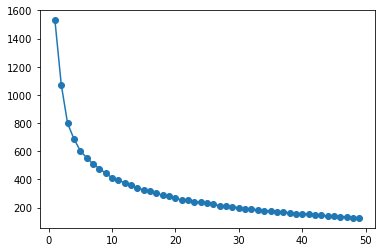

In [38]:
def elbow_loss(data):
    if 'location' in data.columns:
        data = data.drop(['location'], axis=1)
        
    # Normalize the data first
    data = StandardScaler().fit_transform(data)

    # Fit cluster number use elbow method
    costs = []
    clusters = [i for i in range(1, 50)]

    for n in clusters:
        kmeans = KMeans(n_clusters=n, init='k-means++', n_init=20)
        kmeans.fit(data)
        costs.append(kmeans.inertia_)

    plt.plot(clusters, costs, '-o')
    
elbow_loss(full_country_data)

In [48]:
silhouette_score_list = []
cluster_labels_list = []
davies_bouldin_list = []
distortion_method_list = []
elbow_method_list = []
clusters = [i for i in range(2, 50)]

def cluster(data, clusters):    
    if 'location' in data.columns:
        data = data.drop(['location'], axis=1)
    
    data = StandardScaler().fit_transform(data)
        
    kmeans = KMeans(n_clusters=clusters, init='k-means++', n_init=20)
    kmeans.fit(data)
    cluster_labels = kmeans.labels_
    distortion_method_list.append(sum(np.min(cdist(data, kmeans.cluster_centers_, 'euclidean'),axis=1)) / data.shape[0]) 
    elbow_method_list.append(kmeans.inertia_)
    silhouette_score_list.append(silhouette_score(data,cluster_labels))
    cluster_labels_list.append(cluster_labels)
    davies_bouldin_list.append(davies_bouldin_score(data,cluster_labels))

    #print(len(labels))
    #print(labels)
    
#     data['cluster'] = cluster_labels
#     country_cluster = data[['cluster']]
    
    #return country_cluster

In [49]:
for i in range(2, 50):
    cluster(full_country_data, i)

    #country_cluster.head()


0.300935584376679
2
4
[3 3 2 0 1 2 2 1 1 2 3 1 3 3 3 2 0 2 2 2 2 2 2 2 1 3 2 3 1 1 2 2 3 3 3 2 3
 2 2 1 1 1 3 1 2 2 2 0 3 1 2 3 1 2 1 3 1 2 3 3 3 3 3 1 2 2 2 2 1 3 1 2 3 1
 0 1 1 1 2 2 1 2 3 2 2 0 2 2 3 0 2 2 3 2 1 2 2 2 3 2 2 2 3 1 2 2 2 3 3 2 3
 2 3 3 3 2 1 1 3 1 0 3 2 2 2 3 2 1 2 0 2 2 3 0 3 3 1 2 3 2 2 3 3 2 1 1 1 2
 2 3 3 2 2 2 2 2 2 3 3 2 1 1 2 2 2 2 3 2 3 3]
0.9192131238531687
47
49
[43 36 16 23  2 35  0  4  4 35  1 28  1  1 40 22 37  0  3 12  3  6  2  0
 20 44  9 27 26 39  6 32 21 40 36  6 21 48  7 45 22 41 36 28 16 15  6 33
  1 39 12  1 45 38 24 36 41 35 36  1 21  1 36  2  0  7 19  7 22 14 22 25
 17 28 18 39 45 46  3 15 46 42 36 34 25  5 25 35 21 18 19  7  9 12 31 12
 15 16 21  8  7  3  1 45 44  0 16 21  1 29 21 29  9 27 27  7 28  4 17 28
 47 10  7  6 25 30 42 45  6 11 42 12 36 37 43 36 13 14 21  7 22  1 34 19
 46 46  4  9 29 27  1  7 48 25 19 15 32 21 36 16  2  4 15 19 32 14 43  9
 36  9]


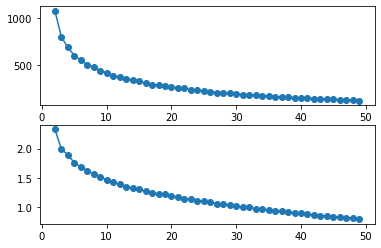

In [53]:
print()

silhouette_score_list_np = np.array(silhouette_score_list)
cluster_labels_list_np = np.array(cluster_labels_list)
davies_bouldin_list_np = np.array(davies_bouldin_list)

max_silhouette_score = np.max(silhouette_score_list_np)
max_sihlouette_score_index = np.argmax(silhouette_score_list_np)
best_cluster_number_silhouette = max_sihlouette_score_index + 2
best_cluster_labels_silhouette = cluster_labels_list_np[max_sihlouette_score_index, :]

print(max_silhouette_score)
print(max_sihlouette_score_index)
print(best_cluster_number_silhouette)
print(best_cluster_labels_silhouette)

min_davies_score = np.min(davies_bouldin_list_np)
min_davies_score_index = np.argmin(davies_bouldin_list_np)
best_cluster_number_davies = min_davies_score_index + 2
best_cluster_labels_davies = cluster_labels_list_np[min_davies_score_index, :]

print(min_davies_score)
print(min_davies_score_index)
print(best_cluster_number_davies)
print(best_cluster_labels_davies)

fig, axs = plt.subplots(2)
axs[0].plot(clusters, elbow_method_list, '-o')
axs[1].plot(clusters, distortion_method_list, '-o')

# Map plot

In [63]:
def build_geodata(shapefile, data):
    map_df = gpd.read_file(shapefile)
    gdf = map_df[['ADM0_A3', 'geometry']].to_crs('+proj=robin')
    
    # Merged is a dataframe with the columns ['ADMO_A3', 'geometry', 'location', 'cluster']
    merged = gdf.merge(country_cluster, how='outer', left_on='ADM0_A3', right_on='iso_code')
    
    return merged

shapefile = "shape_files/ne_10m_admin_0_countries_lakes.shp"

map_df = gpd.read_file(shapefile)

In [67]:
merged = build_geodata(shapefile, country_cluster)
merged.sample(8)

,ADM0_A3,geometry,cluster
126,MMR,"MULTIPOLYGON (((8561091.628 2350547.999, 85617...",0.0
94,NLD,"MULTIPOLYGON (((575752.161 5660240.445, 576112...",1.0
139,PRT,"MULTIPOLYGON (((-754012.248 4485211.117, -7530...",3.0
63,ALB,"POLYGON ((1773102.146 4475067.169, 1771023.236...",0.0
117,GTM,"POLYGON ((-8364688.283 1541762.654, -8364706.7...",0.0
181,CUW,"POLYGON ((-6455626.616 1293883.509, -6452530.5...",NaN
13,ETH,"POLYGON ((3205502.086 1011186.869, 3204950.111...",0.0
36,NAM,"POLYGON ((1501836.533 -3055908.814, 1500093.27...",0.0


In [46]:
keys = list(merged['cluster'].unique())
color_range = list(np.linspace(0, 1, len(keys), endpoint=False))
colors = [plt.cm.tab20b(x) for x in color_range]
color_dict = dict(zip(keys, colors))
color_dict[-1] = 'lightgray'

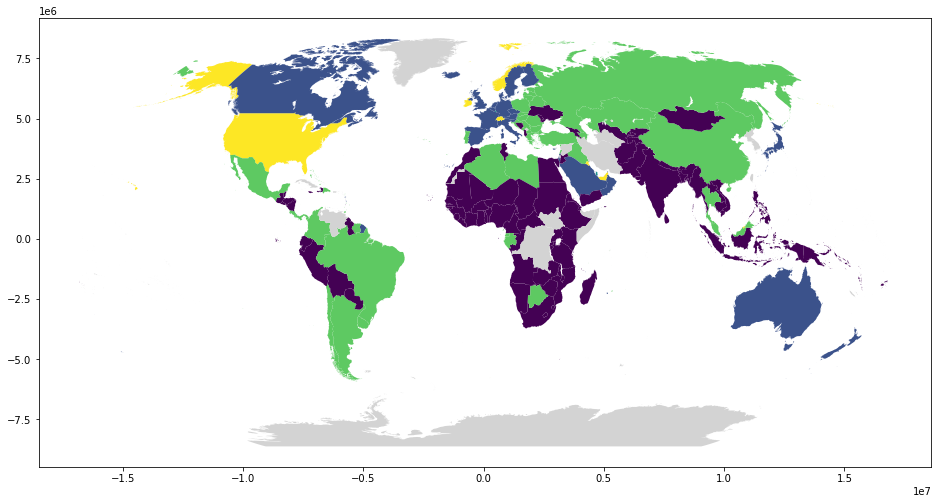

In [68]:
ax = merged.plot(column='cluster', 
                  figsize = (16, 10),
                  missing_kwds={'color': 'lightgrey'},
                  legend=False)

plt.savefig('country_cluster.png')

# Trying PCA

In [18]:
# Load in the data
df = dataset.copy()
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,"UHC SCI components: Reproductive, maternal, newborn and child health",UHC SCI components: Infectious diseases,UHC SCI components: Noncommunicable diseases,UHC SCI components: Service capacity and access,country,cardiovasc,chronic_kidney,copd,diabetes_2,total_cancers
0,ABW,North America,Aruba,2020-03-13,2.0,2.0,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2019-12-31,NaN,0.0,NaN,NaN,0.0,NaN,...,44.0,32.0,56.0,24.0,Afghanistan,0.085553,0.097536,0.022220,0.088591,0.004035
2,AGO,Africa,Angola,2020-03-22,2.0,2.0,NaN,NaN,0.0,NaN,...,45.0,23.0,68.0,35.0,Angola,0.066969,0.060196,0.017916,0.049848,0.003661
3,AIA,North America,Anguilla,2020-03-27,2.0,2.0,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ALB,Europe,Albania,2020-03-09,2.0,2.0,NaN,NaN,0.0,NaN,...,45.0,69.0,56.0,69.0,Albania,0.077390,0.079344,0.017060,0.033545,0.009294


In [79]:
full_country_data = clean_data(relevant_columns, dataset).drop(['location'], axis=1)
full_country_data

,Average (µg/m3),cardiovasc,chronic_kidney,copd,diabetes_2,total_cancers,UHC index of service coverage (SCI),gdp_per_capita,human_development_index
iso_code,,,,,,,,,
AFG,56.910808,0.085553,0.097536,0.022220,0.088591,0.004035,37.0,1803.987,0.498
AGO,32.388505,0.066969,0.060196,0.017916,0.049848,0.003661,40.0,5819.495,0.581
ALB,18.200603,0.077390,0.079344,0.017060,0.033545,0.009294,59.0,11803.431,0.785
ARE,40.917510,0.089068,0.120949,0.030770,0.116674,0.007601,76.0,67293.483,0.863
ARG,13.311834,0.055034,0.075635,0.031957,0.052296,0.011912,76.0,18933.907,0.825
...,...,...,...,...,...,...,...,...,...
VUT,11.652777,0.076038,0.104658,0.016749,0.107841,0.004648,48.0,2921.909,0.603
YEM,50.456007,0.083621,0.090789,0.021268,0.048273,0.003524,42.0,1479.147,0.452
ZAF,25.102205,0.069851,0.081581,0.023379,0.058139,0.005498,69.0,12294.876,0.699


In [92]:
def do_pca(data, retained_var=0.99):
       
    # Standardize the data to have a mean of ~0 and a variance of 1
    X_std = StandardScaler().fit_transform(data)
    
    n = len(data.columns)
    model = PCA(n_components=n, iterated_power='auto', svd_solver='auto', whiten=True)
    model.fit_transform(X_std)
    var = model.explained_variance_ratio_.cumsum()
    print(var)
                
    for i in range(n):
        if var[i] >= retained_var:
            pca = PCA(n_components=i)
    
            principalComponents = pca.fit_transform(X_std)# Plot the explained variances
            features = range(pca.n_components_)
            plt.bar(features, pca.explained_variance_ratio_, color='black')
            plt.xlabel('PCA features')
            plt.ylabel('variance %')
            plt.xticks(features)# Save components to a DataFrame
            PCA_components = pd.DataFrame(principalComponents)
            
            break
    
    return PCA_components

[0.431 0.638 0.748 0.839 0.903 0.954 0.978 0.993 1.   ]


,0,1,2,3,4,5,6
0,2.529235,1.683462,1.391354,0.255547,-0.551583,0.892270,-0.036192
1,2.209047,-0.860242,0.138843,-0.163438,0.587016,0.565678,0.193806
2,0.340870,-0.361100,0.286652,-1.514264,0.052002,-0.321116,0.251963
3,-2.140279,3.019551,1.712288,0.925484,-0.195894,0.470889,1.282365
4,-1.294519,-1.406929,-0.750563,0.639560,-0.407608,-0.033475,-0.225601
...,...,...,...,...,...,...,...
165,1.191072,1.720978,-0.860356,-0.577977,-0.310051,1.600906,0.241957
166,2.713719,0.569385,1.297121,-0.327115,-0.640703,0.076587,0.323659
167,0.294525,-0.100802,-0.090678,-0.156006,-0.254616,-0.003555,-0.032344
168,1.768841,-1.247063,-0.282374,-0.444820,0.554276,-0.018100,-0.044313


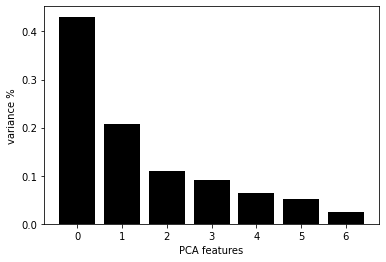

In [93]:
PCA_components = do_pca(full_country_data)
PCA_components

In [88]:
def elbow_loss_pca(data):
    loss = []
    
    ks = range(1, 10)
    for k in range(1, 10):
        # Create a KMeans instance with k clusters: model
        model = KMeans(init='k-means++', n_clusters=k, n_init=10)

        # Fit model to samples
        model.fit(data)

        # Append the inertia to the list of inertias
        loss.append(model.inertia_)
        
    plt.plot(ks, loss, '-o', color='black')
    plt.xlabel('number of clusters, k')
    plt.ylabel('inertia')
    plt.xticks(ks)
    plt.show()

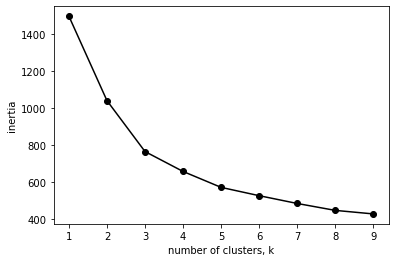

In [89]:
elbow_loss_pca(PCA_components)

In [90]:
merged = build_geodata(shapefile, PCA_components)
merged.sample(8)

,ADM0_A3,geometry,cluster
180,LKA,"MULTIPOLYGON (((7715815.298 758497.178, 771611...",0.0
19,TZA,"MULTIPOLYGON (((3097434.715 -1006193.062, 3096...",0.0
104,SVN,"POLYGON ((1147251.339 4856444.680, 1147400.351...",1.0
35,BLR,"POLYGON ((1914447.145 5483372.933, 1913937.101...",3.0
93,IRN,"MULTIPOLYGON (((3908412.382 4238074.506, 39087...",NaN
187,SPM,"MULTIPOLYGON (((-4702567.698 4993227.006, -470...",NaN
7,CYP,"MULTIPOLYGON (((3009012.519 3740778.293, 30089...",1.0
60,BEL,"POLYGON ((205168.682 5439147.958, 206798.165 5...",1.0


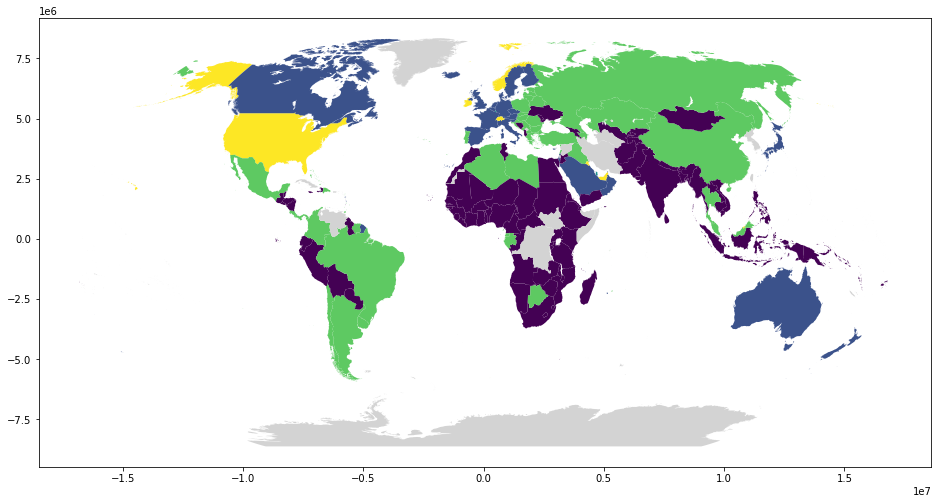

In [91]:
ax = merged.plot(column='cluster', 
                  figsize = (16, 10),
                  missing_kwds={'color': 'lightgrey'},
                  legend=False)